#### To project the data for future dates: 
##### Dates: From 01-Apr-2021 until 01-Mar-2022
We project the data from 01-Apr-2021 to see how the projection data compares to the real data for the period from 01-Apr-2021 till 23-Jun-2021


<br>

- Vaccination ratio:
                     Approach- linear regression model.
                     Reason - This has to keep increasing because of all the vaccination drives happening in the world. So the max value for vaccination ratio is 1
<br>

- Stringency index: 
                    Approach - ARIMA / linear regression model
                    Reason - This can be projected using a regression model as we see that it keeps decreasing gradually over a period of time.
<br>

- positive rate: 
                    Approach - ARIMA / RNN model
                    Reason - This has got the second highest F-score on the XGboost model and having a good estimate at future point of time(synthetic data) will directly impact our prediction on that future date

<br>

- reproduction rate: 
                    Approach - ARIMA / RNN model
                    Reason - Since this has the highest F-score, our reproduction rate projections will directly impact our Prediction model. We can go ahead and use an ARIMA/RNN model to synthetically this


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sb
import matplotlib.ticker as ticker
import scipy.stats as sp
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import scipy
import math

import xgboost as xgb
from xgboost import plot_importance, plot_tree

%matplotlib inline

In [2]:
sample_df = pd.read_csv("Prepared_data/Global_PreProcessed_dataset_unscaled.csv")
sample_df['date']  = pd.to_datetime(sample_df['date'], format = '%Y-%m-%d')
sample_df = sample_df.set_index('date')

In [3]:
end_date = '01-Mar-2022'

### Synthetically projecting Vaccination ratio

- We know that vaccination has started roughly from Jan-2021. We use these dates to fit the linear regression model from Jan-2021 until 01-May-2021
- From 01-May-2021 until Jun-23 we can see the models performance on this test set

In [4]:
start_date = '01-Jan-2021'
vaccination_df = sample_df.loc[sample_df.index>=start_date].copy()

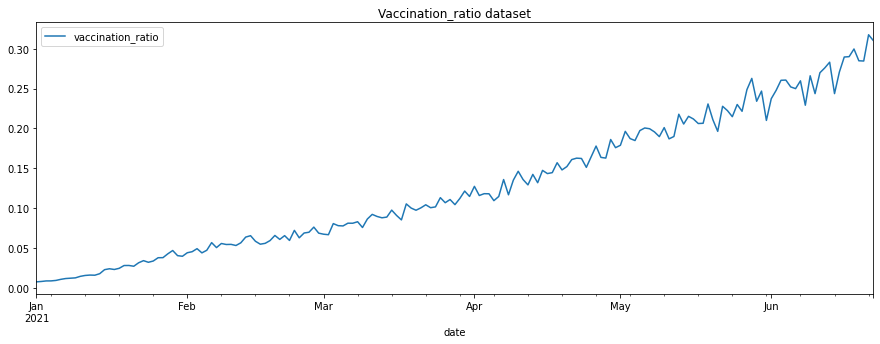

In [5]:
vaccination_df = vaccination_df.drop(['new_deaths_per_million','reproduction_rate','positive_rate','stringency_index'],axis=1)

_ = vaccination_df.plot(figsize=(15,5), title='Vaccination_ratio dataset')

In [6]:
# To have a reference from a start date 
vaccination_df['days_from_start'] = (vaccination_df.index - vaccination_df.index[0]).days

In [7]:
vaccination_df = vaccination_df.loc[vaccination_df.vaccination_ratio !=0]

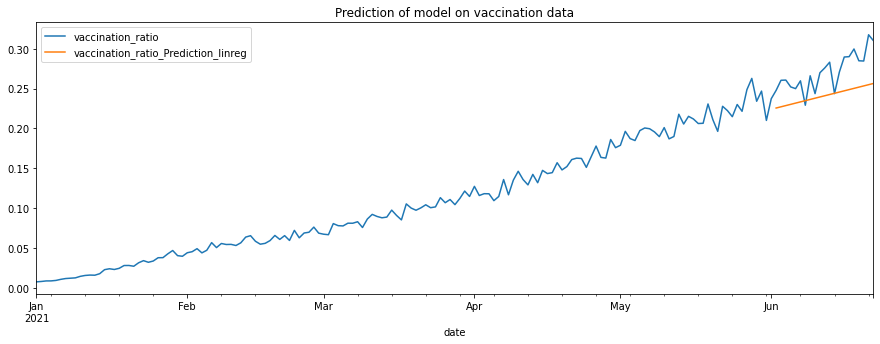

In [8]:
split_date = '01-Jun-2021'
vaccination_df_train = vaccination_df.loc[vaccination_df.index <= split_date].copy()
vaccination_df_test = vaccination_df.loc[vaccination_df.index > split_date].copy()

X_train = vaccination_df_train.drop(['vaccination_ratio'],axis=1)
y_train = pd.DataFrame(vaccination_df_train['vaccination_ratio'])

X_test = vaccination_df_test.drop(['vaccination_ratio'],axis=1)
y_test = pd.DataFrame(vaccination_df_test['vaccination_ratio'])

model = linear_model.LinearRegression().fit(X_train, y_train)#
vaccination_df_test['vaccination_ratio_Prediction_linreg'] = model.predict(X_test) 

vaccination_df_all = pd.concat([vaccination_df_train,vaccination_df_test], sort=False)
_ = vaccination_df_all[['vaccination_ratio','vaccination_ratio_Prediction_linreg']].plot(figsize=(15, 5),title="Prediction of model on vaccination data")

> We see that vaccination ratio is not exactly linear. It is more of exponential. This can b explained by the fact that there are more vaccination drives happening and people are getting vaccinated faster w.r.t time
> Alternative is to go ahead to fit the vaccation_ratio using a simple Neural network which can handle curves
   - The vaccination ratio has a max_limit of 1, so we can go ahead and use a sigmoid function in our final layer of NN
   - The hidden layer

In [9]:
days = pd.date_range(start='2021-06-22', end=end_date)
future_projections = pd.DataFrame(data=days, index = range(len(days)), columns=['date'])
future_projections = future_projections.set_index('date')
#projection_10_months = vaccination_df.append(projection_10_months)

In [10]:
future_projections['days_from_start'] = (future_projections.index - vaccination_df.index[0]).days
visualization_df = future_projections.copy()
future_projections['vaccination_ratio'] = model.predict(future_projections) 

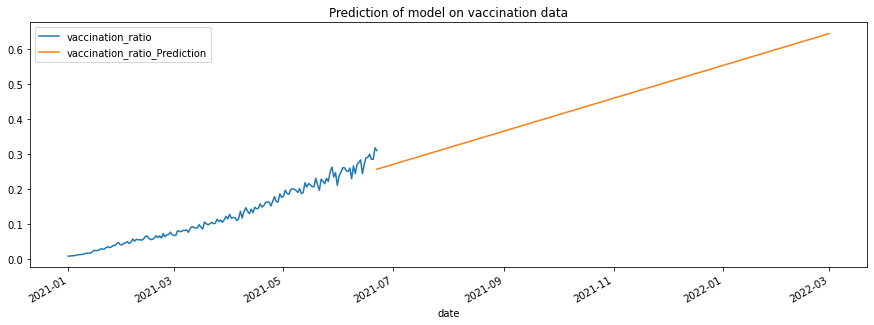

In [11]:
# We create a separate dataframe so that we can visualize it
visualization_df['vaccination_ratio_Prediction'] = model.predict(visualization_df) 
visualization_df = vaccination_df.append(visualization_df)
_ = visualization_df[['vaccination_ratio','vaccination_ratio_Prediction']].plot(figsize=(15, 5),title="Prediction of model on vaccination data")

This is our synthetic data, however this can be improved by using a simple neural network to capture the non linearity mentioned previously. 

In [12]:
vaccination_ratio_future_projections = future_projections

### Synthetically projecting Stringency Index


In [13]:
future_projections.insert(loc=2,column='stringency_index',value=[0.0]*len(future_projections))

In [14]:
stringency_df = sample_df.drop(sample_df.columns.difference(['stringency_index']), 1, inplace=False)

In [15]:
stringency_df = stringency_df.fillna(0)

In [16]:
from pmdarima import auto_arima
  
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


## We try to find the best arima model for our data
# Fit auto_arima function to our dataset
stepwise_fit = auto_arima(stringency_df['stringency_index'], start_p = 1, start_q = 1,
                          max_p = 5, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1363.800, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1191.180, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1123.744, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1326.621, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1233.661, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1212.761, Time=0.21 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1105.956, Time=0.49 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1316.252, Time=0.10 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=1216.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  539
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -480.332
Date:                              Sun, 27 Jun 2021   AIC                            970.664
Time:                                      13:39:58   BIC                            991.991
Sample:                                           0   HQIC                           979.014
                                              - 539                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2539      0.027      9.434      0.000       0.201       0.307
ma.L2          0.2631      0.020     13.366      0.000       0.225       0.302
ma.L3          0.5204      0.029     17.692      0.000       0.463       0.578
ma.S.L12      -0.8807      0.034    -26.190      0.000      -0.947      -0.815
sigma2         0.3509      0.010     36.923      0.000       0.332       0.370
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):              8609.00
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

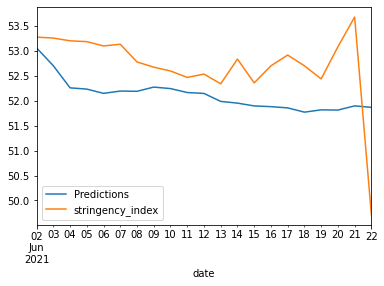

In [18]:
split_date = '01-Jun-2021'
stringency_df_train = stringency_df.loc[stringency_df.index <= split_date].copy()
stringency_df_test = stringency_df.loc[stringency_df.index > split_date].copy()

# (4, 1, 0)x(2, 1, [1], 12)
# Fit a SARIMAX(0, 1, 3)x(0, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(stringency_df_train['stringency_index'],
                order = (0, 1, 3), 
                seasonal_order =(0, 1, [1], 12))

result = model.fit()
#result.summary()

start = len(stringency_df_train)
end = len(stringency_df_train) + len(stringency_df_test) - 1
  
# Predictions against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
stringency_df_test['stringency_index'].plot(legend = True)

Here we can see that the SARIMAX model has gathered a trend in our data, we now use this model to forecast future stringency_index

,days_from_start,vaccination_ratio,stringency_index
date,,,
2021-06-22,172,0.256474,51.868969
2021-06-23,173,0.258015,51.790031
2021-06-24,174,0.259557,51.771781
2021-06-25,175,0.261098,51.611657
2021-06-26,176,0.262640,51.577481
...,...,...,...
2022-02-25,420,0.638754,43.853864
2022-02-26,421,0.640295,43.899959
2022-02-27,422,0.641837,43.895360


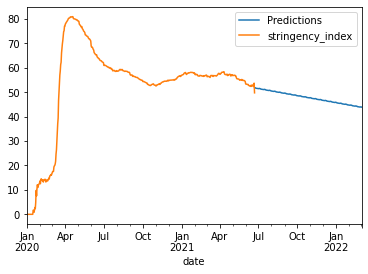

In [19]:
start = len(stringency_df)-1
end = len(stringency_df)+len(future_projections) - 1
  
# Predictions against the test set
stringency_predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")

# plot predictions and actual values
stringency_predictions.plot(legend = True)
stringency_df['stringency_index'].plot(legend = True)

result.predict(start, end,typ = 'levels').rename("Predictions")

future_projections['stringency_index'] = stringency_predictions
future_projections

- Well this what the future holds for us in terms of Stringency_index

### Synthetically projecting reproduction_rate

In [20]:
future_projections.insert(loc=2,column='reproduction_rate',value=[0.0]*len(future_projections))
rrate_df = sample_df.drop(sample_df.columns.difference(['reproduction_rate']), 1, inplace=False)

In [21]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


## We try to find the best arima model for our data
# Fit auto_arima function to our dataset
stepwise_fit = auto_arima(rrate_df['reproduction_rate'], start_p = 1, start_q = 1,
                          max_p = 5, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-595.894, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-776.979, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-600.839, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-824.068, Time=0.79 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.62 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-824.877, Time=0.55 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-775.523, Time=0.17 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.55 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-824.349, Time=0.89 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-823.156, Time=1.49 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-824.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  539
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 415.438
Date:                            Sun, 27 Jun 2021   AIC                           -824.877
Time:                                    13:41:03   BIC                           -812.081
Sample:                                         0   HQIC                          -819.867
                                            - 539                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7091      0.009    -77.436      0.000      -0.727      -0.691
ar.S.L24      -0.3100      0.009    -32.866      0.000      -0.328      -0.291
sigma2         0.0119   8.32e-05    143.121      0.000       0.012       0.012
===================================================================================
Ljung-Box (L1) (Q):                   1.31   Jarque-Bera (JB):            523067.29
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             8.35
Prob(H) (two-sided):                  0.00   Kurtosis:                       156.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

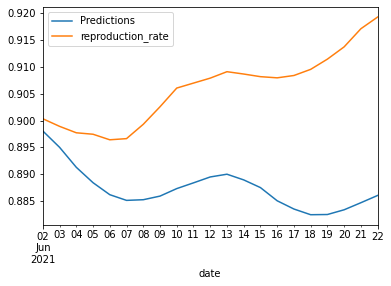

In [31]:

split_date = '01-Jun-2021'

rrate_df_train = rrate_df.loc[rrate_df.index <= split_date].copy()
rrate_df_test = rrate_df.loc[rrate_df.index > split_date].copy()

# Fit a SARIMAX(0, 1, 0)x(0, 1, [1], 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(rrate_df_train['reproduction_rate'], 
                order = (0, 1, 0), 
                seasonal_order =(2, 1, 0, 12))
  
result = model.fit()
#result.summary()

start = len(rrate_df_train)
end = len(rrate_df_train) + len(rrate_df_test) - 1
  
# Predictions against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
rrate_df_test['reproduction_rate'].plot(legend = True)

The model has gathered an overall trend, however it is far from the actual. 


,days_from_start,vaccination_ratio,reproduction_rate,stringency_index,positive_rate
date,,,,,
2021-06-22,172,0.256474,0.886064,51.868969,0.0
2021-06-23,173,0.258015,0.887335,51.790031,0.0
2021-06-24,174,0.259557,0.888973,51.771781,0.0
2021-06-25,175,0.261098,0.889609,51.611657,0.0
2021-06-26,176,0.262640,0.888440,51.577481,0.0
...,...,...,...,...,...
2022-02-25,420,0.638754,0.806695,43.853864,0.0
2022-02-26,421,0.640295,0.806359,43.899959,0.0
2022-02-27,422,0.641837,0.806788,43.895360,0.0


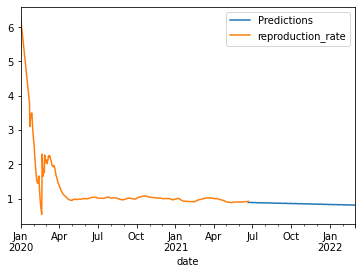

In [32]:
start = len(rrate_df)-1
end = len(rrate_df)+len(future_projections) - 1
  
# Predictions against the test set
rrate_predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")

# plot predictions and actual values
rrate_predictions.plot(legend = True)
rrate_df['reproduction_rate'].plot(legend = True)

result.predict(start, end,typ = 'levels').rename("Predictions")

future_projections['reproduction_rate'] = rrate_predictions
future_projections

We see that the trend is a declining which is on par with our data so far

###  Synthetically projecting positive_rate

In [35]:
future_projections.insert(loc=4,column='positive_rate',value=[0.0]*len(future_projections))
pr_df = sample_df.drop(sample_df.columns.difference(['positive_rate']), 1, inplace=False)

ValueError: cannot insert positive_rate, already exists

In [37]:
from pmdarima import auto_arima
  
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


## We try to find the best arima model for our data
# Fit auto_arima function to our dataset
stepwise_fit = auto_arima(pr_df['positive_rate'], start_p = 1, start_q = 1,
                          max_p = 5, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-4327.317, Time=1.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4177.824, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4283.873, Time=0.88 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-4325.747, Time=0.96 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-4193.613, Time=0.28 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-4317.333, Time=1.93 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-4337.073, Time=4.03 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-4336.527, Time=2.75 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-4335.431, Time=3.28 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-4329.051, Time=3.16 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=-4353.937, Time=5.18 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=-4344.738, Time=1.78 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-4366.966, Time=9.88 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=-4335.089, Time=1.70 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  539
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                2190.483
Date:                                 Sun, 27 Jun 2021   AIC                          -4366.966
Time:                                         13:49:07   BIC                          -4337.109
Sample:                                              0   HQIC                         -4355.276
                                                 - 539                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2564      0.120     -2.134      0.033      -0.492      -0.021
ar.L2         -0.2175      0.028     -7.889      0.000      -0.271      -0.163
ma.L1          0.0264      0.127      0.208      0.835      -0.222       0.275
ar.S.L12      -0.2783      0.503     -0.554      0.580      -1.263       0.707
ma.S.L12      -0.3358      0.502     -0.669      0.503      -1.319       0.647
ma.S.L24      -0.2225      0.317     -0.702      0.483      -0.844       0.399
sigma2      1.395e-05   3.95e-07     35.343      0.000    1.32e-05    1.47e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              3784.80
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

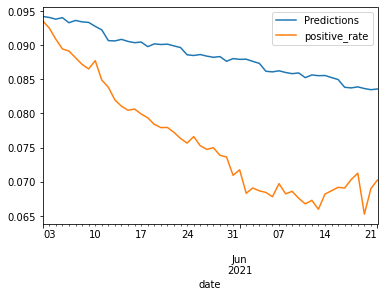

In [38]:
split_date = '01-May-2021'

pr_df_train = pr_df.loc[pr_df.index <= split_date].copy()
pr_df_test = pr_df.loc[pr_df.index > split_date].copy()

# Fit the best SARIMAX model obtained from above on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(pr_df_train['positive_rate'], 
                order = (2, 1, 1), 
                seasonal_order =(1, 1, [1,2], 12))
  
result = model.fit()
#result.summary()

start = len(pr_df_train)
end = len(pr_df_train) + len(pr_df_test) - 1
  
# Predictions against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")

# plot predictions and actual values
predictions.plot(legend = True)
pr_df_test['positive_rate'].plot(legend = True)

The SARIMAX model has gathered an overall trend in our data

,days_from_start,vaccination_ratio,reproduction_rate,stringency_index,positive_rate
date,,,,,
2021-06-22,172,0.256474,0.886064,51.868969,0.083573
2021-06-23,173,0.258015,0.887335,51.790031,0.082886
2021-06-24,174,0.259557,0.888973,51.771781,0.083282
2021-06-25,175,0.261098,0.889609,51.611657,0.083173
2021-06-26,176,0.262640,0.888440,51.577481,0.083199
...,...,...,...,...,...
2022-02-25,420,0.638754,0.806695,43.853864,0.034274
2022-02-26,421,0.640295,0.806359,43.899959,0.034428
2022-02-27,422,0.641837,0.806788,43.895360,0.034184


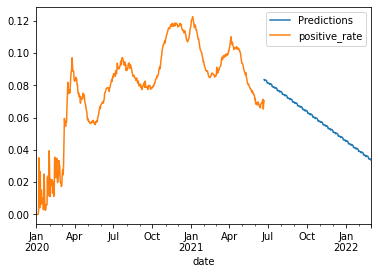

In [39]:
start = len(rrate_df)-1
end = len(rrate_df)+len(future_projections) - 1

# Predictions against the test set
pr_predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")

# plot predictions and actual values
pr_predictions.plot(legend = True)
pr_df['positive_rate'].plot(legend = True)

result.predict(start, end,typ = 'levels').rename("Predictions")

future_projections['positive_rate'] = pr_predictions
future_projections

In [43]:
future_projections = future_projections.drop("days_from_start",axis = 1)

In [44]:
future_projections.to_csv('Prepared_data/Projection_Global_PreProcessed_dataset_unscaled.csv')